#Modelo predictivo de diagnosticos de cancer de mama.
###Dataset utilizado: "Breast Cancer Dataset" de la plataforma Kaggle (uso plublico).
###Algoritmo de clasificación: eXtreme Gradient Boosting (XGBoost).
###Tecnicas de inteligencia artificial explicativa (XAI): SHAP y LIME.

###Instalación de librerias necesarias para el uso de XAI

In [ ]:
!pip install shap
!pip install lime

###Importación de las librerias necesarias para el modelo.

In [ ]:
import os
import kagglehub

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shap
shap.initjs()
import xgboost as xgb

from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score, classification_report
from scipy.stats import randint, uniform
from lime.lime_tabular import LimeTabularExplainer

###Exportación del dataset

In [ ]:
#Se guarda la ruta de acceso al dataset.
file_path = '/content/drive/MyDrive/breast-cancer.csv'

#Se lee y guarda el dataset dentro de la variable 'df'.
df = pd.read_csv(file_path)

###Preprocesado de los datos.

In [ ]:
#Se crea la variable 'le' para luego usarla para convertir datos categoricos a numericos.
le = LabelEncoder()

#Se elimina la columna 'id' ya que no es relevante para la predicción.
df.drop(["id"], axis=1, inplace=True)

#Se selecciona la columna de 'diagnosis' para convertir sus datos de categoricos a numericos.
df["diagnosis"] = le.fit_transform(df["diagnosis"])

#Se imprimen los datos para confirmar los cambios.
print(df.head())

#Se imprime la cantidad de filas y columnas dentro del dataset luego de los cambios.
df.shape

   diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          1        17.99         10.38          122.80     1001.0   
1          1        20.57         17.77          132.90     1326.0   
2          1        19.69         21.25          130.00     1203.0   
3          1        11.42         20.38           77.58      386.1   
4          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0         0.2419  ...         25.38          

(569, 31)

###Busqueda de datos nulos.

In [ ]:
#Se busca si existen datos nulos dentro de las columnas.
df.isnull().sum()

,0
diagnosis,0
radius_mean,0
texture_mean,0
perimeter_mean,0
area_mean,0
smoothness_mean,0
compactness_mean,0
concavity_mean,0
concave points_mean,0
symmetry_mean,0


###Visualización del contenido de 'diagnosis'.

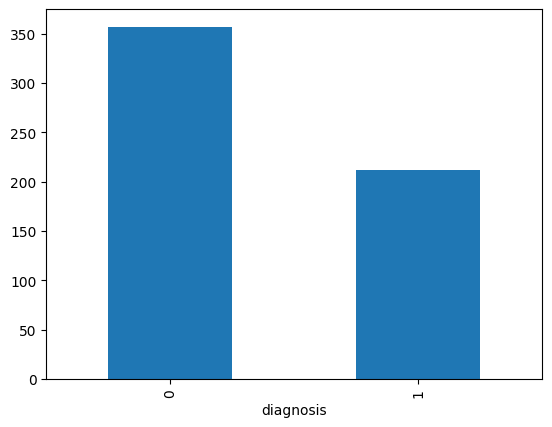

,count
diagnosis,
0,357
1,212


In [ ]:
#Se guarda la columna 'diagnosis' como objetivo
target = df["diagnosis"]

#Se guardan los datos de la columna.
data = target.value_counts()

#Se genera un grafico de barra para visualizar la cantidad de casos de cancer maligno (1) y benigno (0)
data.plot(kind='bar')
plt.show()

#Entrega el numero de datos correspondiente a cada valor de la columna.
target.value_counts()

###Correlación entre las caracteristicas y 'diagnosis'.

In [ ]:
#Se guarda la correlación existente entre las variables y 'diagnosis'.
corr = df.corr()['diagnosis'].sort_values(ascending=False)

#Se imprime la correlación de las variables en orden descendente.
print(corr)

diagnosis                  1.000000
concave points_worst       0.793566
perimeter_worst            0.782914
concave points_mean        0.776614
radius_worst               0.776454
perimeter_mean             0.742636
area_worst                 0.733825
radius_mean                0.730029
area_mean                  0.708984
concavity_mean             0.696360
concavity_worst            0.659610
compactness_mean           0.596534
compactness_worst          0.590998
radius_se                  0.567134
perimeter_se               0.556141
area_se                    0.548236
texture_worst              0.456903
smoothness_worst           0.421465
symmetry_worst             0.416294
texture_mean               0.415185
concave points_se          0.408042
smoothness_mean            0.358560
symmetry_mean              0.330499
fractal_dimension_worst    0.323872
compactness_se             0.292999
concavity_se               0.253730
fractal_dimension_se       0.077972
symmetry_se               -0

###Visualización de la correlación de las caracteristicas.




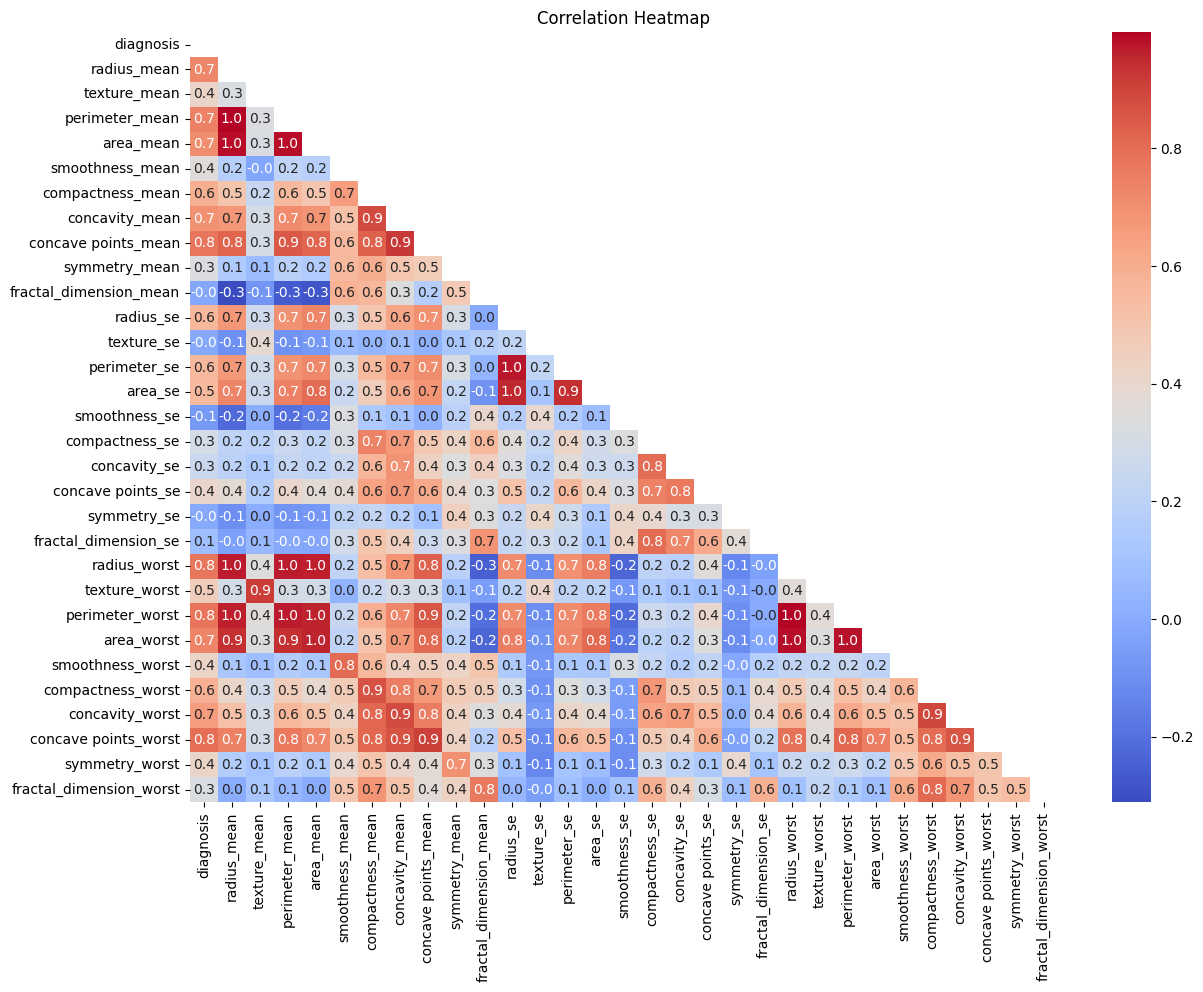

In [ ]:
#Se establecen los atributos del grafico (heatmap) de correlación.
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.1f', cbar=True, mask=np.triu(np.ones_like(df.corr(), dtype=bool)))
plt.title("Correlation Heatmap")
plt.show()

###Descarte de caracteristicas con alta correlación.

In [ ]:
#Se calcula la matriz de correlación
corr_matrix = df.corr().abs()

#Se aplica una mascara para seleccionar solo el triangulo superior de la matriz de correlación.
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

#Se buscan las caracteristicas con una correlación mayor a 0.8 .
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

#Se descartan las caracteristicas con una alta correlación.
df_reduced = df.drop(columns=to_drop)

#Se imprime tanto el dataframe original como el nuevo.
print("DataFrame original:")
print(df.shape)
print("\nDataFrame tras descartar las caracteristicas con alta correlación:")
print(df_reduced.shape)

DataFrame original:
(569, 31)

DataFrame tras descartar las caracteristicas con alta correlación:
(569, 21)


###Preparación de los datos de entrenamiento y prueba.

In [ ]:
#Se selecciona la columna 'diagnosis' del dataframe recortado para el valor y.
y = df_reduced["diagnosis"]

#Se seleccionan todas las demas caracteristicas salvo 'diagnosis'.
X = df_reduced.drop(["diagnosis"], axis=1)

#Se establecen los datos de entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Se crea la variable 'scaler' para luego usarla para normalizar las caracteristicas.
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Se imprimen los datos y columnas de entrenamiento y prueba.
print("x_train shape: ", X_train.shape)
print("x_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (455, 20)
x_test shape:  (114, 20)
y_train shape:  (455,)
y_test shape:  (114,)


###Construcción del modelo y busqueda de sus hiperparametros.

In [ ]:
#Definimos el modelo base.
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

#Definir la grilla de hiperparámetros.
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1, 5]
}

#Configuración del GridSearch.
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10,                  #Se evalúa utilizando validación cruzada de 10 folders.
    verbose=1,
    n_jobs=-1
)

#Ejecutamos la búsqueda.
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:37:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0, 1, 5],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 150, 200],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

###Mejores hiperparametros para el modelo predictivo.

In [ ]:
#Se imprimen los mejores parametros encontrados por el GridSearchCV
print("Mejores hiperparámetros:")
print(grid_search.best_params_)

Mejores hiperparámetros:
{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


###Precision de las predicciones del modelo

In [ ]:
#Se guarda en la variable 'best_model' el mejor modelo obtenido gracias a la busqueda anterior.
best_model = grid_search.best_estimator_

#Se realizan predicciones sobre el conjunto de prueba (X_test) usando el mejor modelo.
y_pred = best_model.predict(X_test)

#Se imprime la precisión del modelo y el reporte.
print("Accuracy en el conjunto de prueba:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy en el conjunto de prueba: 0.9736842105263158
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        71
           1       0.95      0.98      0.97        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



###Matriz de confusión del modelo.

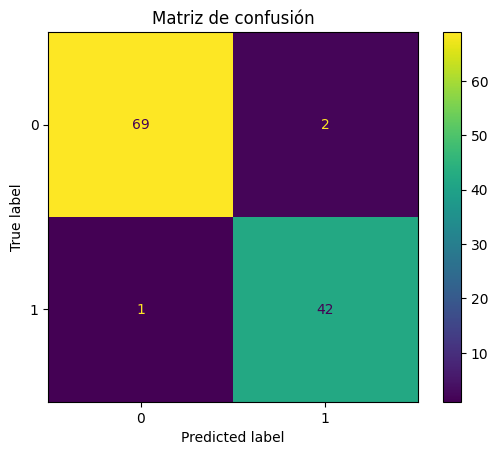

In [ ]:
# Matriz de confusión.
labels = np.unique(y)
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.title("Matriz de confusión")
plt.show()

###Visualización del area bajo la curva del modelo.

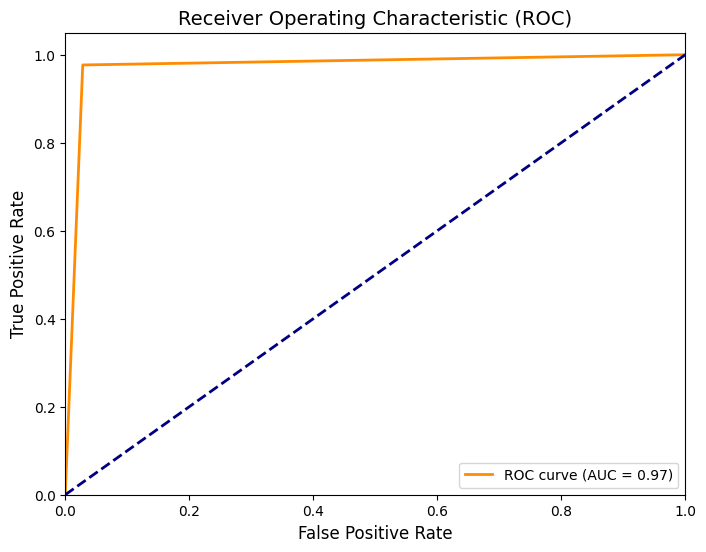

In [ ]:
#Se grafica el area bajo la curva del modelo.
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Receiver Operating Characteristic (ROC)", fontsize=14)
plt.legend(loc="lower right")
plt.show()

###Sensibilidad y especificidad del modelo.

In [ ]:
#Calcular sensibilidad y especificidad desde la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

sensibilidad = tp / (tp + fn)
especificidad = tn / (tn + fp)

#Se Imprimen la sensibilidad y especificidad
print(f"Sensibilidad (Recall): {sensibilidad:.2f}")
print(f"Especificidad: {especificidad:.2f}")

Sensibilidad (Recall): 0.98
Especificidad: 0.97


###Grafico general de valores SHAP.

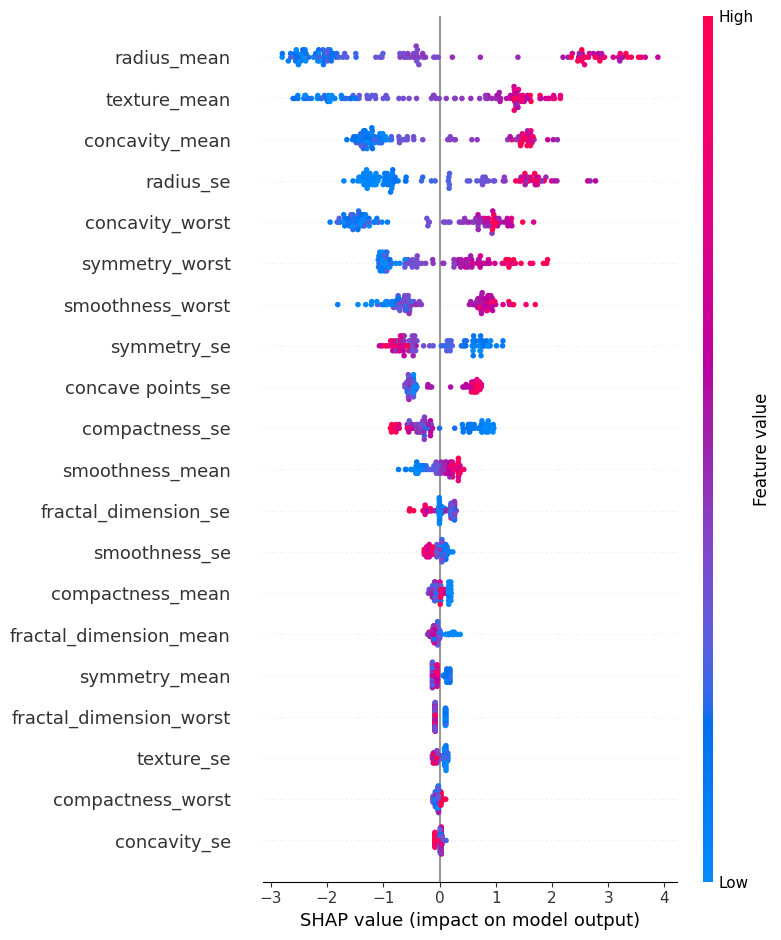

In [ ]:
#Se crea un 'explicador' utilizando el 'shap.TreeExplainer' con el mejor modelo.
explainer = shap.TreeExplainer(best_model)

#Se calculan los valores SHAP del conjunto de prueba.
shap_values = explainer.shap_values(X_test)

#Se realiza una grafica general de estos valores
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

###Grafico de dependencia entre 'symmetry_se' y 'radius_mean'.

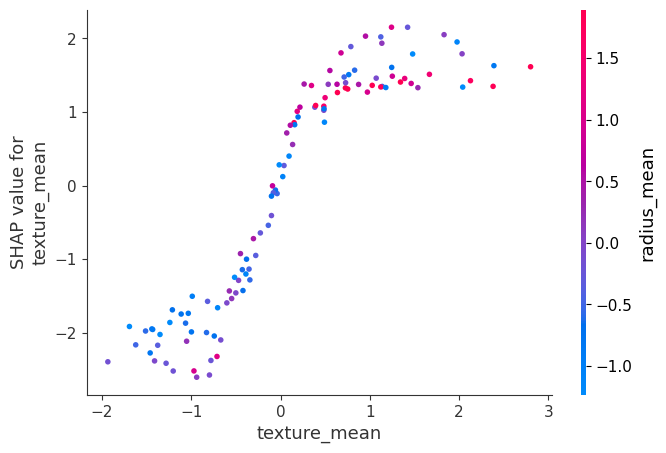

In [ ]:
#Se genera una grafica de dependencia entre la caracteristica 'texture_mean' y 'radius_mean'.
shap.dependence_plot("texture_mean", shap_values, X_test, interaction_index="radius_mean", feature_names=X.columns)

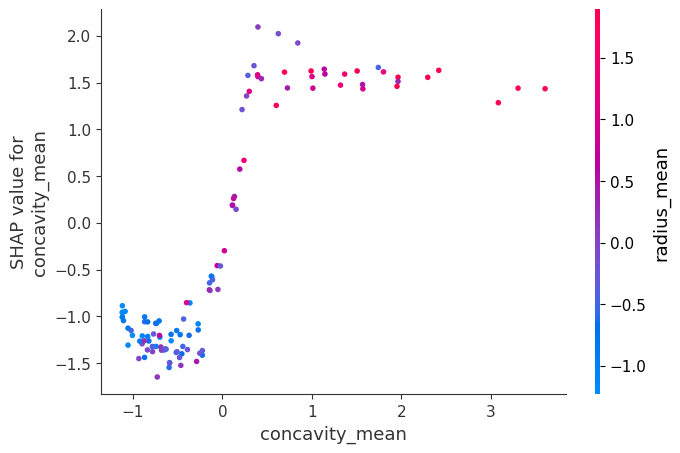

In [ ]:
#Se genera una grafica de dependencia entre la caracteristica 'concavity_mean' y 'radius_mean'.
shap.dependence_plot("concavity_mean", shap_values, X_test, interaction_index="radius_mean", feature_names=X.columns)

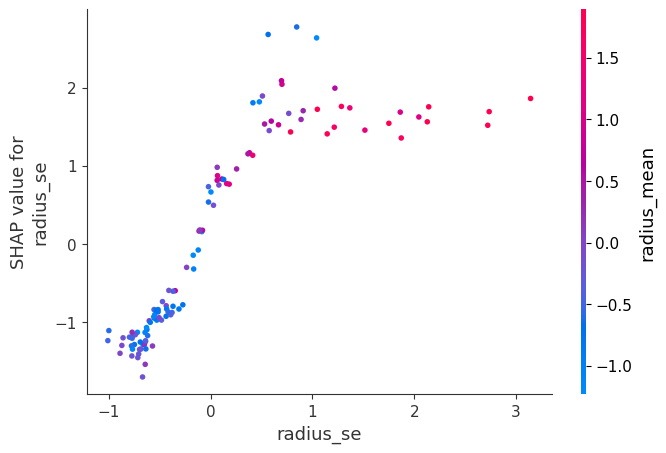

In [ ]:
#Se genera una grafica de dependencia entre la caracteristica 'radius_se' y 'radius_mean'.
shap.dependence_plot("radius_se", shap_values, X_test, interaction_index="radius_mean", feature_names=X.columns)

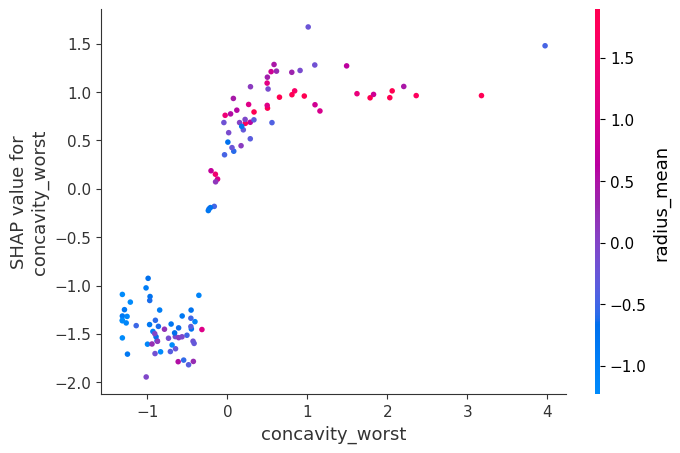

In [ ]:
#Se genera una grafica de dependencia entre la caracteristica 'concavity_worst' y 'radius_mean'.
shap.dependence_plot("concavity_worst", shap_values, X_test, interaction_index="radius_mean", feature_names=X.columns)

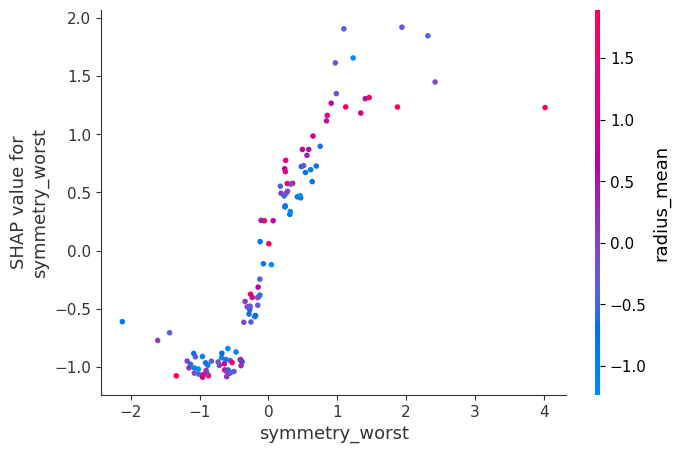

In [ ]:
#Se genera una grafica de dependencia entre la caracteristica 'symmetry_worst' y 'radius_mean'.
shap.dependence_plot("symmetry_worst", shap_values, X_test, interaction_index="radius_mean", feature_names=X.columns)

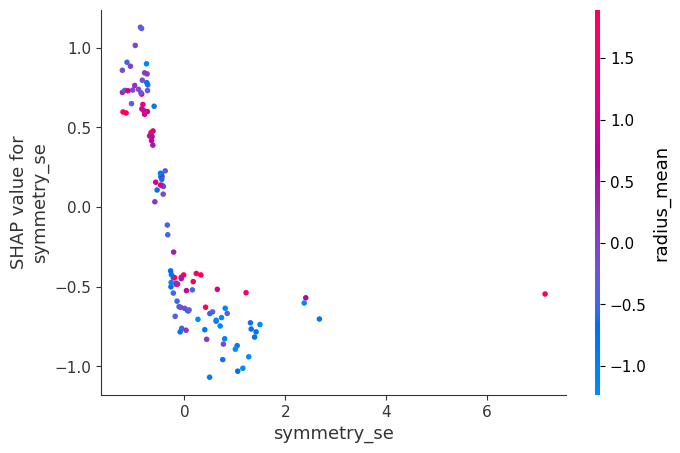

In [ ]:
#Se genera una grafica de dependencia entre la caracteristica 'symmetry_se' y 'radius_mean'.
shap.dependence_plot("symmetry_se", shap_values, X_test, interaction_index="radius_mean", feature_names=X.columns)

###Casos de prueba.

In [ ]:
#Se imprimen los casos 11 y 14
print(y_test.iloc[14])
print(y_test.iloc[11])

0
1


###Grafico de fuerza del caso 14 (Benigno).

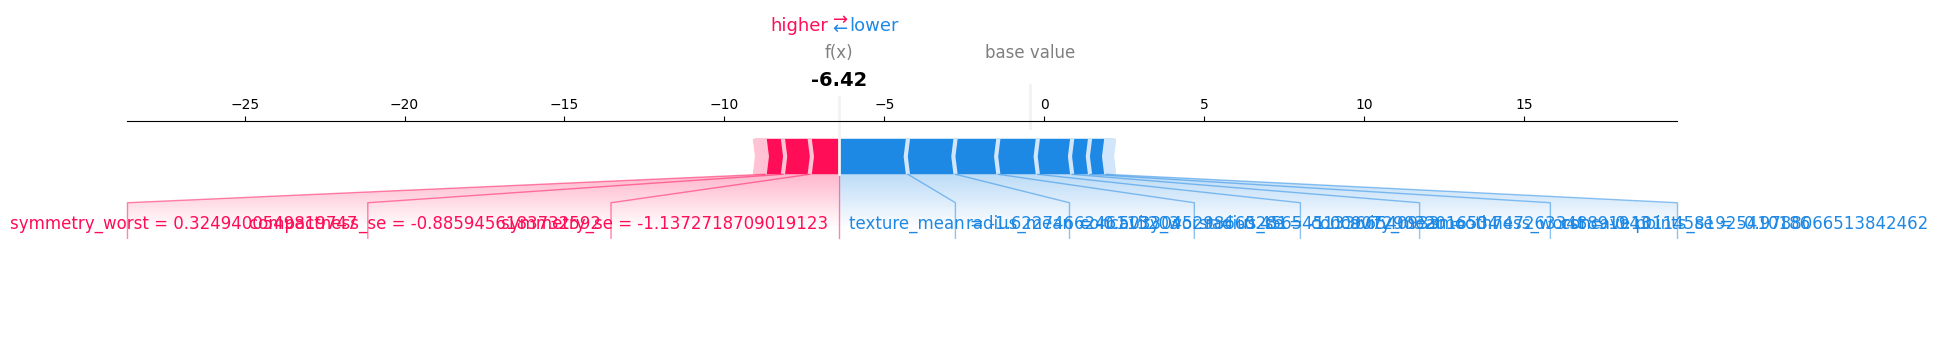

In [ ]:
#Se realiza un grafico de fuerza en relación con el caso 14 (caso benigno).
shap.plots.force(explainer.expected_value, shap_values[14, :], X_test[14, :], matplotlib=True, feature_names=X.columns)

###Grafico de fuerza del caso 11 (Maligno).

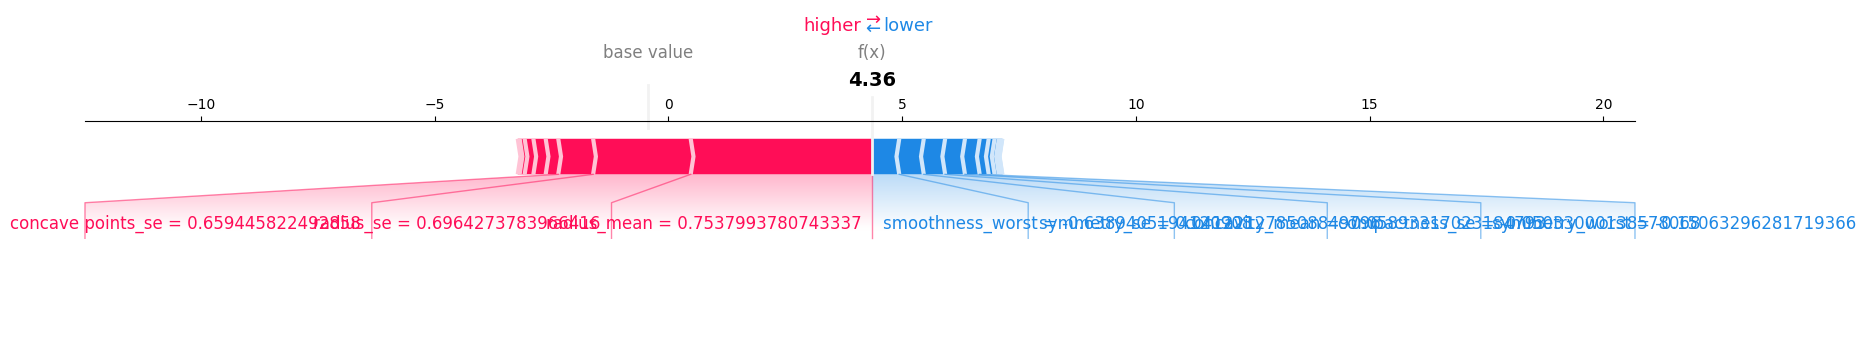

In [ ]:
#Se realiza un grafico de fuerza en relación con el caso 11 (caso maligno).
shap.plots.force(explainer.expected_value, shap_values[11, :], X_test[11, :], matplotlib=True, feature_names=X.columns)

###Grafico de decisiones del caso 14 (Benigno).



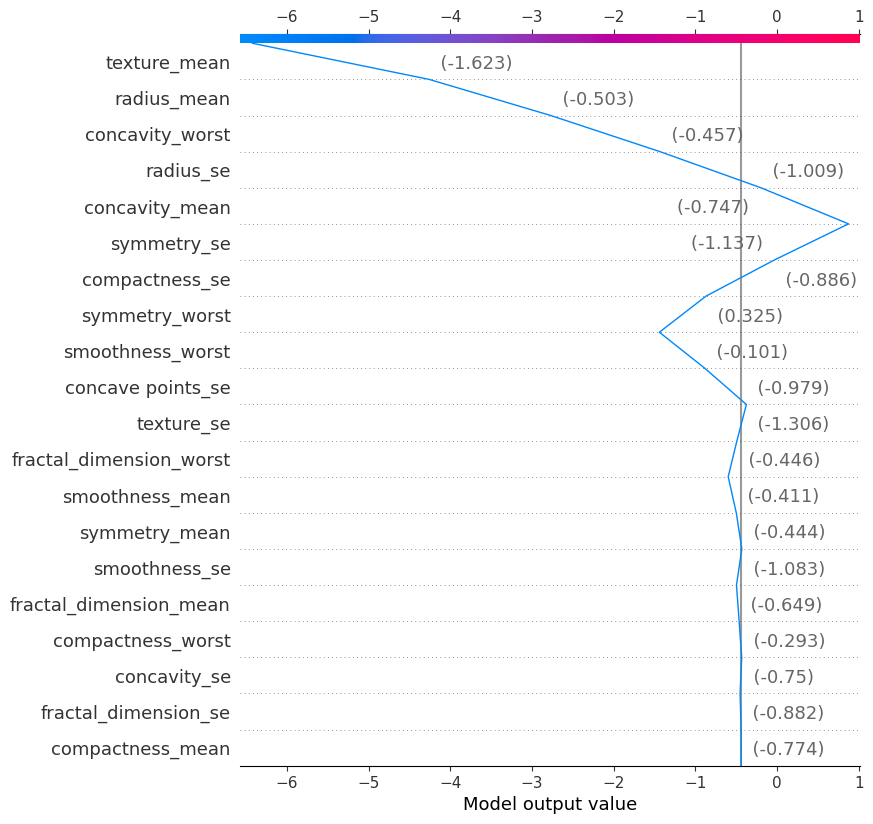

In [ ]:
#Se realiza un grafico de decisiones del caso 14 (Caso benigno).
shap.decision_plot(explainer.expected_value, shap_values[14, :], X_test[14, :], X.columns.tolist())

###Grafico de decisiones del caso 11 (Maligno).

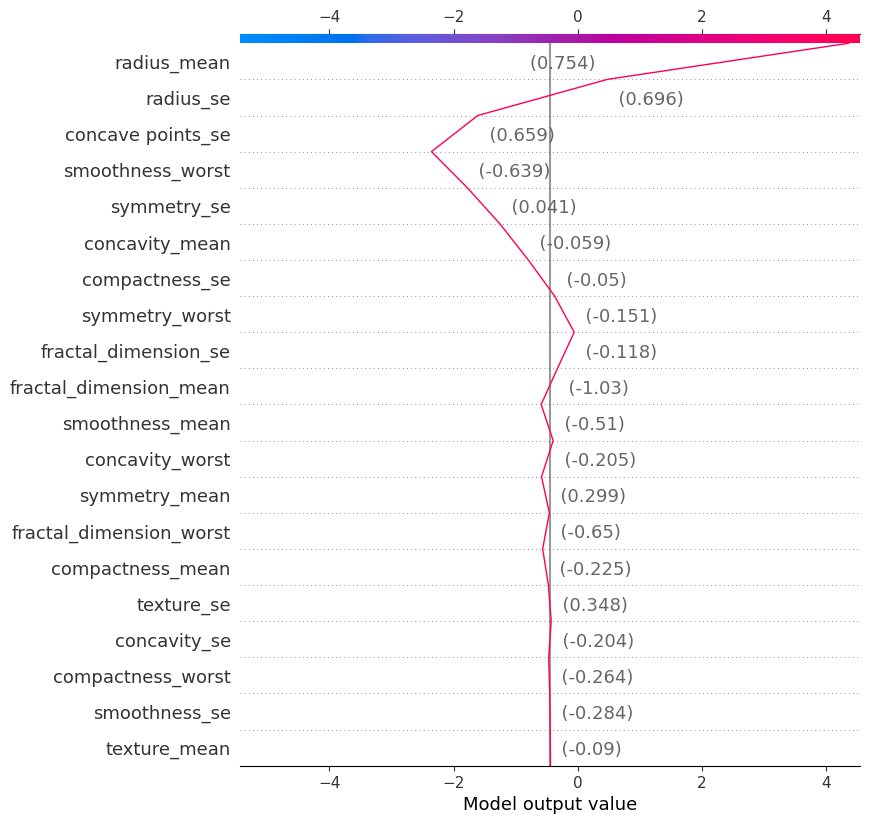

In [ ]:
#Se realiza un grafico de decisiones del caso 11 (Caso Maligno).
shap.decision_plot(explainer.expected_value, shap_values[11, :], X_test[11, :], X.columns.tolist())

###Grafico LIME de influencia a nivel local.

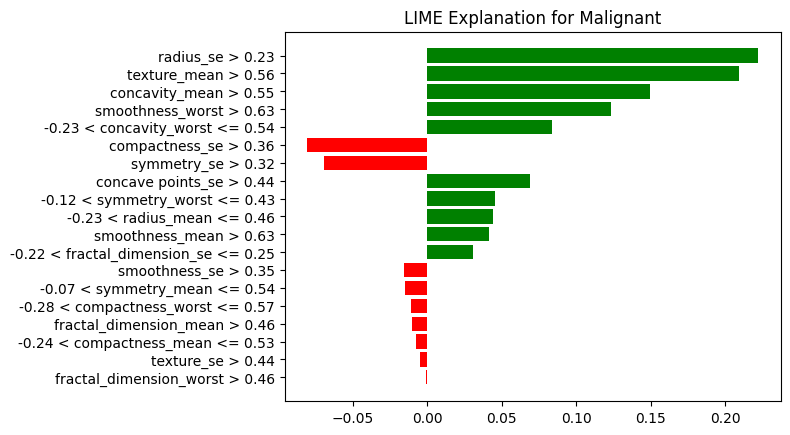

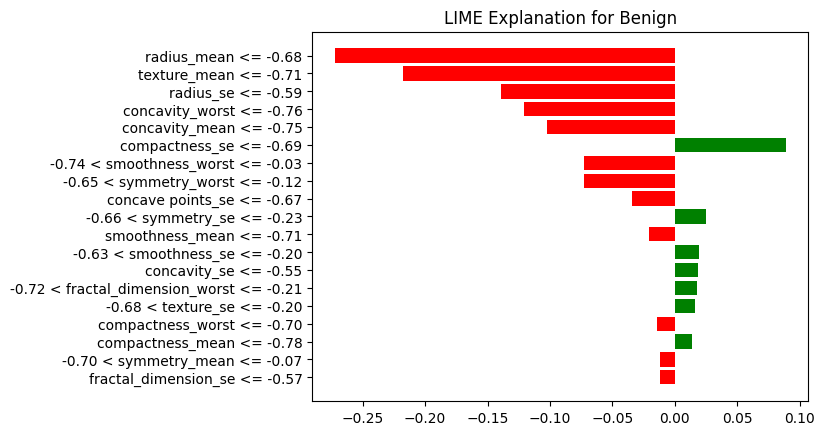

In [ ]:
# Se definen los nombres de las clases según el problema de clasificación (por ejemplo, cáncer benigno o maligno)
class_names = ['Benigno', 'Maligno']

# Se obtiene la lista de nombres de características a partir del conjunto de entrenamiento
feature_names = list(X.columns)

# Se crea el explicador LIME configurado para problemas de clasificación tabular.
# Este explicador utilizará las instancias de entrenamiento para generar explicaciones locales.
explainer = LimeTabularExplainer(X_train,
                                 feature_names=feature_names,
                                 class_names=class_names,
                                 mode='classification')

# Identificación de índices en el conjunto de prueba para cada clase
# Aquí se asume que el valor 1 representa la clase "Maligno" y 0 la clase "Benigno"
malignant_indices = y_test[y_test == 1].index
benign_indices = y_test[y_test == 0].index

# === Explicación de una instancia de la clase "Maligno" ===

# Se filtran los índices para asegurarse de que estén dentro del rango válido de X_test
valid_malignant_indices = malignant_indices[malignant_indices < len(X_test)]

# Se selecciona la primera instancia válida de la clase "Maligno"
i_malignant = valid_malignant_indices[0]

# Se genera una explicación local usando LIME para la instancia seleccionada
# 'num_features=19' indica cuántas características incluir en la explicación
exp_malignant = explainer.explain_instance(X_test[i_malignant],
                                           best_model.predict_proba,
                                           num_features=19)

# Visualización de la explicación para la instancia maligna
exp_malignant.as_pyplot_figure()
plt.title('LIME Explanation for Malignant')
plt.show()

# === Explicación de una instancia de la clase "Benigno" ===

# Se filtran los índices para asegurarse de que estén dentro del rango válido de X_test
valid_benign_indices = benign_indices[benign_indices < len(X_test)]

# Se selecciona la primera instancia válida de la clase "Benigno"
i_benign = valid_benign_indices[0]

# Se genera una explicación local usando LIME para la instancia seleccionada
exp_benign = explainer.explain_instance(X_test[i_benign],
                                        best_model.predict_proba,
                                        num_features=19)

# Visualización de la explicación para la instancia benigna
exp_benign.as_pyplot_figure()
plt.title('LIME Explanation for Benign')
plt.show()